In [14]:
import copy
from qutip import *
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns
import h5py
import uuid
from datetime import datetime

mpl.rcParams['figure.dpi'] = 200

# First Seed
This notebook demonstrates the initial seeding process where we start in all $|g>$ and a THz-photon pushes one atom in $|r>$. Afterwards this atom should generate somewhere else a $|e>$ excitation through dipole-dipole interaction (between er).

This state is later on the starting point for the avalanche (other notebook).

## Define Constants

In [15]:
N_spins = 7
N_phonons = 3

OmegaGE = 1
kappa = 3
omegaTrap = 8
V_vdw = 200
DeltaEE = -V_vdw  # weil resonant

tlist = np.linspace(0, 3, 50)

GammaEg = 0
GammaEe = 0

In [16]:
def multiSpinOperator(op, numOfParticles, dim=2):
    retOp = []
    for i in range(numOfParticles):
        if i == 0:
            retOp.append(op)
        else:
            retOp.append(qeye(dim))
        for j in range(numOfParticles - 1):
            if j + 1 == i:
                retOp[i] = tensor(retOp[i], op)
            else:
                retOp[i] = tensor(retOp[i], qeye(dim))
    return retOp

In [17]:
g = basis(2, 0)
e = basis(2, 1)
a = destroy(N_phonons)
g

Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[1.]
 [0.]]

## Create Hamiltonian

In [18]:
#tempOpReshape = qeye([2, N_phonons])
tempOpReshape = qeye(2 * N_phonons)
tempOpReshape.data = tensor(e * g.dag() + g * e.dag(), qeye(N_phonons)).data
H_OmegaGE = OmegaGE * sum(multiSpinOperator(tempOpReshape, N_spins, dim=tempOpReshape.dims[0]))
tempOpReshape.data = tensor(e * e.dag(), qeye(N_phonons)).data
H_DeltaEE = DeltaEE * sum(multiSpinOperator(tempOpReshape, N_spins, dim=tempOpReshape.dims[0]))
tempOpReshape.data = tensor(qeye(2), num(N_phonons) + 0.5).data
H_phon = omegaTrap * sum(multiSpinOperator(tempOpReshape, N_spins, dim=tempOpReshape.dims[0]))

In [19]:
H_OmegaGE

Quantum object: dims = [[6, 6, 6, 6, 6, 6, 6], [6, 6, 6, 6, 6, 6, 6]], shape = (279936, 279936), type = oper, isherm = True
Qobj data =
  (0, 3)	(1+0j)
  (0, 18)	(1+0j)
  (0, 108)	(1+0j)
  (0, 648)	(1+0j)
  (0, 3888)	(1+0j)
  (0, 23328)	(1+0j)
  (0, 139968)	(1+0j)
  (1, 4)	(1+0j)
  (1, 19)	(1+0j)
  (1, 109)	(1+0j)
  (1, 649)	(1+0j)
  (1, 3889)	(1+0j)
  (1, 23329)	(1+0j)
  (1, 139969)	(1+0j)
  (2, 5)	(1+0j)
  (2, 20)	(1+0j)
  (2, 110)	(1+0j)
  (2, 650)	(1+0j)
  (2, 3890)	(1+0j)
  (2, 23330)	(1+0j)
  (2, 139970)	(1+0j)
  (3, 0)	(1+0j)
  (3, 21)	(1+0j)
  (3, 111)	(1+0j)
  (3, 651)	(1+0j)
  :	:
  (279932, 279284)	(1+0j)
  (279932, 279824)	(1+0j)
  (279932, 279914)	(1+0j)
  (279932, 279935)	(1+0j)
  (279933, 139965)	(1+0j)
  (279933, 256605)	(1+0j)
  (279933, 276045)	(1+0j)
  (279933, 279285)	(1+0j)
  (279933, 279825)	(1+0j)
  (279933, 279915)	(1+0j)
  (279933, 279930)	(1+0j)
  (279934, 139966)	(1+0j)
  (279934, 256606)	(1+0j)
  (279934, 276046)	(1+0j)
  (279934, 279286)	(1+0j)
  (279934, 2

In [20]:
tempOpReshape.data = tensor(e * e.dag(), qeye(N_phonons)).data
multiEe = multiSpinOperator(tempOpReshape, N_spins, dim=tempOpReshape.dims[0])

tempOpReshape.data = tensor(e * e.dag(), a).data
multiNa = multiSpinOperator(tempOpReshape, N_spins, dim=tempOpReshape.dims[0])

tempOpReshape.data = tensor(e * e.dag(), a.dag()).data
multiNaDag = multiSpinOperator(tempOpReshape, N_spins, dim=tempOpReshape.dims[0])

In [21]:
H_vdw = 0 * H_DeltaEE
for i in range(N_spins):
    H_vdw += V_vdw * multiEe[i] * multiEe[(i + 1) % N_spins]
    #H_vdw -= V_vdw/ np.sqrt(omegaTrap) * (multiNaDag[i] * multiEe[(i + 1) % N_spins]
    #                                       + multiNa[i] * multiEe[(i + 1) % N_spins]
    #                                       - multiNa[(i + 1) % N_spins] * multiEe[i]
    #                                       - multiNaDag[(i + 1) % N_spins] * multiEe[i])
    H_vdw -= kappa * (multiNaDag[i] * multiEe[(i + 1) % N_spins]
                      + multiNa[i] * multiEe[(i + 1) % N_spins]
                      - multiNa[(i + 1) % N_spins] * multiEe[i]
                      - multiNaDag[(i + 1) % N_spins] * multiEe[i])

In [22]:
H = H_OmegaGE + H_DeltaEE + H_vdw + H_phon
H

Quantum object: dims = [[6, 6, 6, 6, 6, 6, 6], [6, 6, 6, 6, 6, 6, 6]], shape = (279936, 279936), type = oper, isherm = True
Qobj data =
  (0, 0)	(28+0j)
  (0, 3)	(1+0j)
  (0, 18)	(1+0j)
  (0, 108)	(1+0j)
  (0, 648)	(1+0j)
  (0, 3888)	(1+0j)
  (0, 23328)	(1+0j)
  (0, 139968)	(1+0j)
  (1, 1)	(36+0j)
  (1, 4)	(1+0j)
  (1, 19)	(1+0j)
  (1, 109)	(1+0j)
  (1, 649)	(1+0j)
  (1, 3889)	(1+0j)
  (1, 23329)	(1+0j)
  (1, 139969)	(1+0j)
  (2, 2)	(44+0j)
  (2, 5)	(1+0j)
  (2, 20)	(1+0j)
  (2, 110)	(1+0j)
  (2, 650)	(1+0j)
  (2, 3890)	(1+0j)
  (2, 23330)	(1+0j)
  (2, 139970)	(1+0j)
  (3, 0)	(1+0j)
  :	:
  (279932, 279935)	(1+0j)
  (279933, 139965)	(1+0j)
  (279933, 256605)	(1+0j)
  (279933, 276045)	(1+0j)
  (279933, 279285)	(1+0j)
  (279933, 279825)	(1+0j)
  (279933, 279915)	(1+0j)
  (279933, 279930)	(1+0j)
  (279933, 279933)	(124+0j)
  (279934, 139966)	(1+0j)
  (279934, 256606)	(1+0j)
  (279934, 276046)	(1+0j)
  (279934, 279286)	(1+0j)
  (279934, 279826)	(1+0j)
  (279934, 279916)	(1+0j)
  (279934, 2

## Create Jump Operators

In [23]:
L_eg = []
L_ee = []
#for i in range(N_spins):
#    L_eg += [tensor(multiSpinOperator(np.sqrt(GammaEg) * g * e.dag(), N_spins)[i],phonEye)]
#    L_ee += [tensor(multiSpinOperator(np.sqrt(GammaEe) * e * e.dag(), N_spins)[i],phonEye)]
#c_ops = [L_eg, L_ee]

## Initial state
All atoms in $|g>$ or one in $|r>$

In [24]:
g0 = basis(2 * N_phonons, 0)
e0 = basis(2 * N_phonons, N_phonons)
psiSpin = g0
for i in range(N_spins - 1):
    if i == N_spins // 2 - 1:
        psiSpin = tensor(psiSpin, e0)
    else:
        psiSpin = tensor(psiSpin, g0)
psi0 = psiSpin
e0

Quantum object: dims = [[6], [1]], shape = (6, 1), type = ket
Qobj data =
[[0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]]

## expectation values

In [52]:
eOps = []
tempOpReshape.data = tensor(e * e.dag(), qeye(N_phonons)).data
eOps += multiSpinOperator(tempOpReshape, N_spins, dim=tempOpReshape.dims[0])
tempOpReshape.data = tensor(qeye(2), num(N_phonons)).data
eOps += multiSpinOperator(tempOpReshape, N_spins, dim=tempOpReshape.dims[0])
tempOpReshape.data = tensor(qeye(2), destroy(N_phonons)).data
eOps += multiSpinOperator(tempOpReshape, N_spins, dim=tempOpReshape.dims[0])
tempOpReshape.data = tensor(qeye(2), create(N_phonons)).data
eOps += multiSpinOperator(tempOpReshape, N_spins, dim=tempOpReshape.dims[0])
# this is only to create an array with the same amount of observables (6) as in the mps-code
tempOpReshape.data = tensor(qzero(2), qzero(N_phonons)).data
eOps += multiSpinOperator(tempOpReshape, N_spins, dim=tempOpReshape.dims[0])
eOps += multiSpinOperator(tempOpReshape, N_spins, dim=tempOpReshape.dims[0])

In [53]:
res0 = sesolve(H, psi0, tlist, e_ops=eOps, progress_bar=True)  #,c_ops=c_ops)

10.0%. Run time:   4.07s. Est. time left: 00:00:00:36
20.0%. Run time:   8.24s. Est. time left: 00:00:00:32
30.0%. Run time:  12.31s. Est. time left: 00:00:00:28
40.0%. Run time:  16.64s. Est. time left: 00:00:00:24
50.0%. Run time:  21.21s. Est. time left: 00:00:00:21
60.0%. Run time:  25.79s. Est. time left: 00:00:00:17
70.0%. Run time:  30.36s. Est. time left: 00:00:00:13
80.0%. Run time:  35.64s. Est. time left: 00:00:00:08
90.0%. Run time:  41.35s. Est. time left: 00:00:00:04
Total run time:  45.93s


In [54]:
np.array(res0.expect).shape

(42, 50)

In [55]:
res1 = copy.deepcopy(res0)
res1 = np.array(res1.expect).reshape(N_spins, 6, len(tlist), order='F')

## Plots

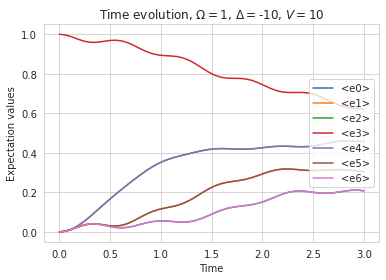

In [56]:
plt.figure()
for i, r in enumerate(res1[:, 0, :]):
    plt.plot(tlist, r, label='<e' + str(i) + '>')
plt.title(r'Time evolution, $\Omega=$' + str(OmegaGE) + ', $\Delta=$' + str(DeltaEE) + ', $V=$' + str(V_vdw))
plt.xlabel('Time')
plt.ylabel('Expectation values')
plt.legend(loc='right')
plt.show()

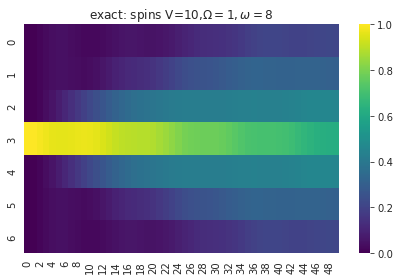

In [57]:
sns.heatmap(res1[:, 0, :], cmap="viridis", vmin=0, vmax=1)
plt.title(r'exact: spins V={},$\Omega={},\omega={}$'.format(V_vdw, OmegaGE, omegaTrap))
plt.tight_layout()
plt.show()

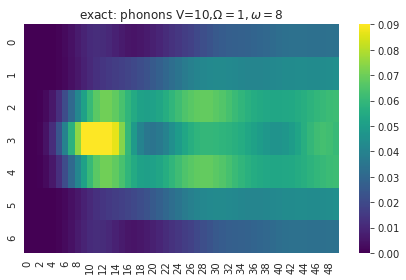

In [58]:
sns.heatmap(np.array(res1[:, 1, :]), cmap="viridis", vmin=0, vmax=0.09)
plt.title(r'exact: phonons V={},$\Omega={},\omega={}$'.format(V_vdw, OmegaGE, omegaTrap))
plt.tight_layout()
plt.show()

In [59]:
filename = 'comparisonWithMPS'
f = h5py.File(filename + '.h5', 'w')

# store now all calculated values to a hdf5 dataset
res_ds = f.create_dataset(uuid.uuid4().hex, data=res1, compression="gzip", compression_opts=9)
# TODO save observable data in separate dataframes
res_ds.attrs['observables'] = ['e', 'n_a','a','a_dag','bond_dim','entropy']
# store metadata which correspond to the dataset
res_ds.attrs['N_spins'] = N_spins
res_ds.attrs['N_phonons'] = N_phonons
res_ds.attrs['max_bond'] = -1
res_ds.attrs['Omega'] = OmegaGE
res_ds.attrs['omegaTrap'] = omegaTrap
res_ds.attrs['V_vdw'] = V_vdw
res_ds.attrs['DeltaEE'] = DeltaEE
res_ds.attrs['kappa'] = kappa
res_ds.attrs['CUTOFF_TOLERANCE'] = -1
res_ds.attrs['TROTTER_TOLERANCE'] = -1
res_ds.attrs['times'] = tlist
res_ds.attrs['Initial state'] = 'all atoms in g, centered in e, fock-state all 0'
res_ds.attrs['alpha'] = -1
res_ds.attrs['beta'] = -1
res_ds.attrs['Date'] = datetime.now().timestamp()
# close the file
f.close()